In [12]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import scipy.stats as stats

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.facecolor'] = 'white'

Xdict = {}
Pdict = {}

In [13]:
def phi_in_gaussian(kx, ky, F2, l):
    k = np.sqrt(kx * kx + ky * ky)
    return kx*kx * np.exp(-k / F2) / ((kx + l*1.0j) * (kx + l*1.0j) - k)

def calculate_wake(F, l=0.002, kmax=64, d=0.03125):
    k = np.arange(-kmax, kmax+d, d)
    n = len(k)
    
    m = (n - 1) / 2
    x = pi / (d * m) * np.arange(-m, m+1, 1)
    
    phi_induced = phi_in_gaussian(k[:, None], k[None, :], \
                                  np.power(F, 2.0), l)
    
    #Rotate grid since dft starts at zero
    phi_grid = np.roll(phi_induced, -m, axis=0)
    phi_grid = np.roll(phi_grid, -m, axis=1)
    
    fPhi = d*d * np.fft.ifft2(phi_grid)
    fPhi = np.roll(fPhi, m, axis=1)
    fPhi = np.roll(fPhi, m, axis=0)
    fPhi = np.transpose(fPhi)
    
    return x, fPhi

In [14]:
#phase = -1.7
phase = 0.25

def draw_wake_plot(ax, x, phi, bound=None, scale=False):
    r = x[-1]
    stdev = np.std(phi)
    if bound is not None:
        avg = np.average(phi)
        ubound = avg + bound * stdev
        lbound = avg - bound * stdev
        toshow = phi * (phi < ubound) * (phi > lbound)
        toshow[phi > ubound] = ubound
        toshow[phi < lbound] = lbound
    else:
        toshow = phi
    if scale:
        toshow -= avg
        toshow = toshow / (ubound - lbound) * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian',
                         vmin=-1, vmax=1)
    else:
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
        rnge = ubound - lbound
        toshow = toshow - lbound - rnge/2
        toshow = toshow / rnge * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian')
    return img

def draw_kelvin_angle(ax, x, x0=[0], color='blue'):
    slope = -np.sqrt(1. / 8.)
    for xz in x0:
        y = slope * (x - xz)
        ax.plot(x[y >= 0], y[y >= 0], color=color, linestyle=':')

def draw_inner_angle(ax, x, T, color='black'):
    slope = np.sqrt(T - 1.) / (2. * T - 1.)
    y = slope * x
    ax.plot(x, -y, color=color, linestyle=':')
    
def draw_parametric_wake(ax, nmax, t, color='black', phase=phase):
    t32 = np.power(t, 1.5)
    xtterm = (2*t - 1) / t32
    ytterm = np.sqrt(t - 1) / t32
    for n in range(1, nmax+1):
        t32 = np.power(t, 1.5)
        xt = -np.pi * (2 * n + 1 + phase) * xtterm
        yt = -np.pi * (2 * n + 1 + phase) * ytterm
        ax.plot(xt, -yt, color=color, linestyle=':')

    
def calc_a_value(slope, f):
    m2 = slope * slope
    T = 1. / (8. * m2) * (1 + 4 * m2 + np.sqrt(1 - 8 * m2))
    return T / (f * f)

a = np.average([calc_a_value(0.05, np.sqrt(128)),
                calc_a_value(0.0459, np.sqrt(128)),
                calc_a_value(0.0328, 16),
                calc_a_value(0.0353, 16)])

def calc_T_value(f, a=a):
    return a * f * f

In [24]:
froudes = np.array([0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8])
nfroudes = len(froudes)
print(nfroudes)
kmax = 64
delta = 1.0 / 16
lambd=0.01
arrsize = int(kmax / delta * 2 + 1)

def generate_wake_patterns(fvals, xdict, pdict):
    for i, f in enumerate(fvals):
        if f >= 2.5:
            x, p = calculate_wake(f, kmax=kmax*2, d=delta, l=lambd)
        else:
            x, p = calculate_wake(f, kmax=kmax, d=delta, l=lambd)
        xdict[f] = np.real(x)
        pdict[f] = np.real(p)
        print('F = %f done' % f)

10


In [25]:
generate_wake_patterns(froudes, Xdict, Pdict)

F = 0.350000 done
F = 0.400000 done
F = 0.450000 done
F = 0.500000 done
F = 0.550000 done
F = 0.600000 done
F = 0.650000 done
F = 0.700000 done
F = 0.750000 done
F = 0.800000 done


In [18]:
def get_slope(xvals, pvals, xrng, ymax):
    py, px = np.gradient(pvals)
    py = np.abs(py)
    
    pymax_data = filters.maximum_filter(py, 5)
    pymax = (py == pymax_data)
    
    labeled, num_objects = ndimage.label(pymax)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = xs[(dx.start + dx.stop - 1)/2]
        y_center = xs[(dy.start + dy.stop - 1)/2]
        
        '''
        We want to run linear regression on this
        Remove all "peaks" due to oscillations of background
        Also remove the "peak" at the left edge of the image since
        it appears only because it is on the boundary
        '''
        if x_center > xrng[0] and x_center < xrng[1] and abs(y_center) < ymax:
            x.append(x_center)
            y.append(y_center)
    
    x = np.array(x)
    y = np.array(y)    
    m1, b1, r1, p1, std1 = stats.linregress(x[y>=0], y[y>=0])
    return m1, b1, x, y

F = 0.35	Slope = -0.168	X-int = 15.650	2 Theta = 19.112 Degrees
F = 0.40	Slope = -0.211	X-int = 8.836	2 Theta = 23.862 Degrees
F = 0.45	Slope = -0.241	X-int = 5.829	2 Theta = 27.107 Degrees
F = 0.50	Slope = -0.269	X-int = 3.747	2 Theta = 30.149 Degrees
F = 0.55	Slope = -0.286	X-int = 2.566	2 Theta = 31.964 Degrees


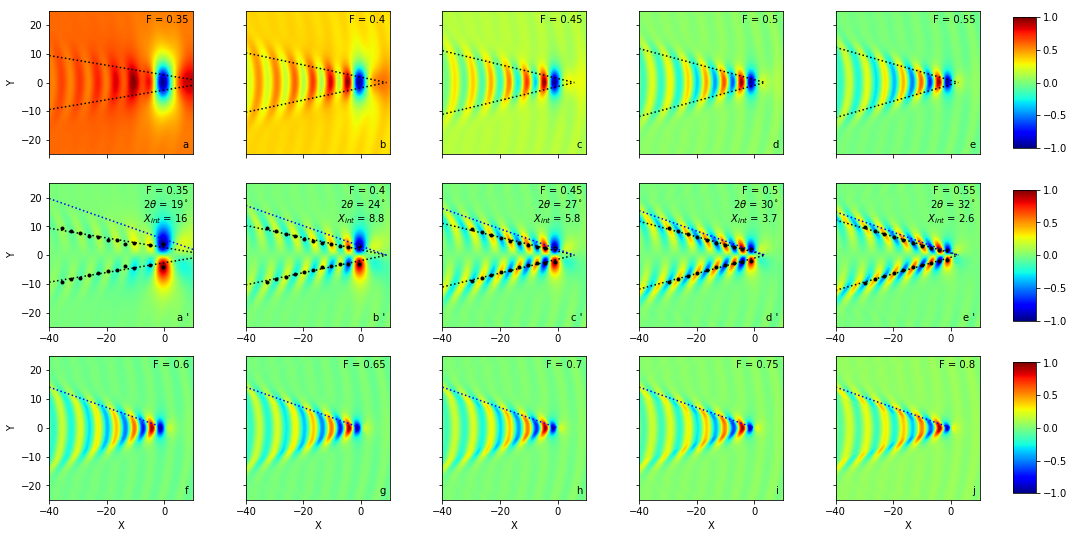

In [32]:
rows = np.array([froudes[0:5],
                  froudes[5:10]])
xbounds = [-40, 10]
ybounds = [-25, 25]
npy, npx = rows.shape

fig = plt.figure(figsize=(16, 4 * npy + 1))
axs, imgs = [None, None, None, None], [None, None, None, None]
label = 'a'

for j in range(npy):
    for i in range(npx):
        ind = i + 1 + (j * 2) * npx
        ax = fig.add_subplot(npy + 1, npx, ind)
        fr = rows[j, i]

        ax.set_xlim(xbounds)
        ax.set_ylim(ybounds)
        ax.text(0.97, 0.97, r'F = %g' % fr, transform=ax.transAxes, 
                    horizontalalignment='right', 
                    verticalalignment='top')
        ax.text(0.97, 0.03, label, transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
        T = a * fr * fr
        xs = Xdict[fr]
        img = draw_wake_plot(ax, xs, Pdict[fr], scale=False)
        
        if j == 0:
            m, b, x_c, y_c = get_slope(xs, Pdict[fr], [xbounds[0], 0], 10)
            twoT = 2 * np.arctan(-m) * 180 / np.pi
            print('F = %.2f\tSlope = %.3f\tX-int = %.3f\t2 Theta = %.3f Degrees' %
                  (fr, m, -b/m, twoT))

            yp = m * xs + b
            xp = xs[yp >= 0]
            yp = yp[yp >= 0]
            ax.plot(xp, yp, 'k', linestyle=':')
            ax.plot(xp, -yp, 'k', linestyle=':')

            #Plot gradient in y direction
            ax1 = fig.add_subplot(npy + 1, npx, ind + npx)
            ax1.set_xlim(xbounds)
            ax1.set_ylim(ybounds)
            ax1.text(0.97, 0.97, 'F = %g\n$2\\theta$ = %.2g$^{\\circ}$\n$X_{int}$ = %.2g' % (fr, twoT, -b/m), 
                     transform=ax1.transAxes, 
                     horizontalalignment='right', 
                     verticalalignment='top')
            ax1.text(0.97, 0.03, label+' \'', transform=ax1.transAxes,
                     horizontalalignment='right',
                     verticalalignment='bottom')
            py, px = np.gradient(Pdict[fr])
            img1 = draw_wake_plot(ax1, xs, py, scale=False)
            ax1.plot(xp, yp, 'k', linestyle=':')
            ax1.plot(xp, -yp, 'k', linestyle=':')
            ax1.plot(x_c, y_c, 'ko', markersize=3)
            draw_kelvin_angle(ax1, xs, x0=[-b/m])
            axs[j*2 + 1] = ax1
            imgs[j*2 + 1] = img1
        else:
            draw_kelvin_angle(ax, xs)

        if j == npy - 1:
            ax.set_xlabel('X')
        else:
            nlbls = len(ax.get_xticklabels())
            ax.set_xticklabels([''] * nlbls)
        if i == 0:
            ax.set_ylabel('Y')
            if j == 0:
                ax1.set_ylabel('Y')
        else:
            #Clear tick labels
            nlbls = len(ax.get_yticklabels())
            ax.set_yticklabels([''] * nlbls)
            if j == 0:
                nlbls = len(ax1.get_yticklabels())
                ax1.set_yticklabels([''] * nlbls)
        axs[2 * j] = ax
        imgs[2 * j] = img
        label = chr(ord(label) + 1)

#Add colorbars
fig.subplots_adjust(right=0.95)
for j in range(npy + 1):
    bb = axs[j].get_position().bounds
    cbar_ax = fig.add_axes([0.97, bb[1]+0.01, 0.02, bb[3]-0.02])
    fig.colorbar(imgs[j], cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1.0])

plt.show()